# Decision Tree Notebook


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import os

In [2]:
# Load the dataset
df = pd.read_csv(r'C:\Users\aryan\Desktop\XAI\XAI_Models\binary\adult_income\adult_income.csv')

# Display the first few rows of the dataframe
print(df.head())
df.head(5)

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


                 age workclass        fnlwgt education  education-num  \
count   32561.000000     32561  3.256100e+04     32561   32561.000000   
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     22696           NaN     10501            NaN   
mean       38.581647       NaN  1.897784e+05       NaN      10.080679   
std        13.640433       NaN  1.055500e+05       NaN       2.572720   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.178270e+05       NaN       9.000000   
50%        37.000000       NaN  1.783560e+05       NaN      10.000000   
75%        48.000000       NaN  2.370510e+05       NaN      12.000000   
max        90.000000       NaN  1.484705e+06       NaN      16.000000   

            marital-status      occupation relationship   race    sex  \
count                32561           32561        

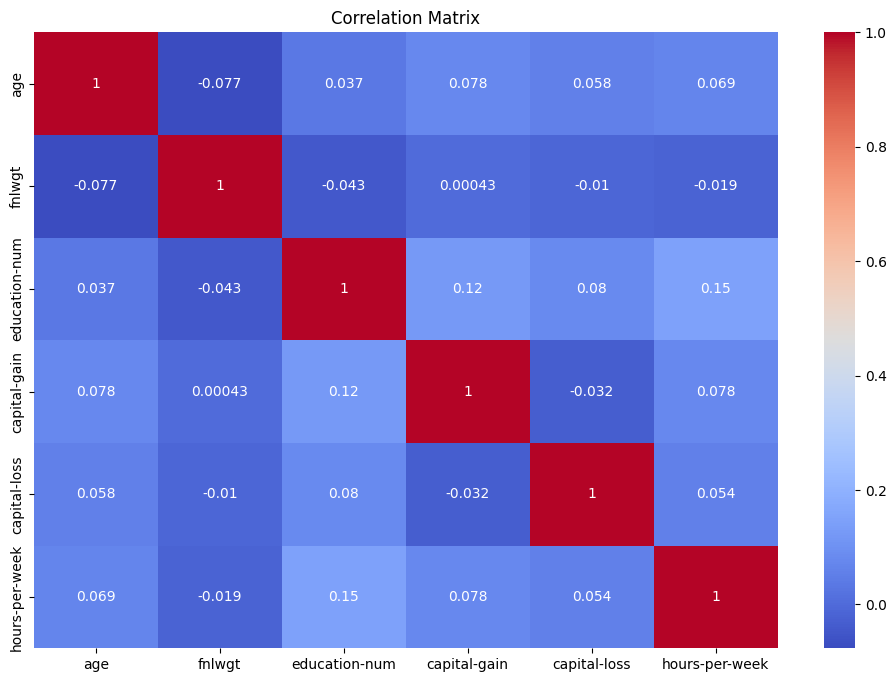

In [3]:
# Display basic statistics
print(df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

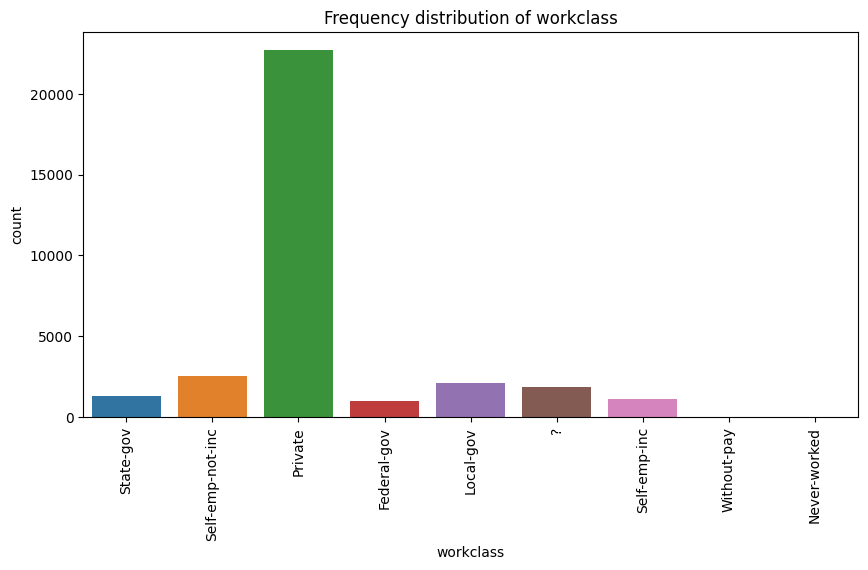

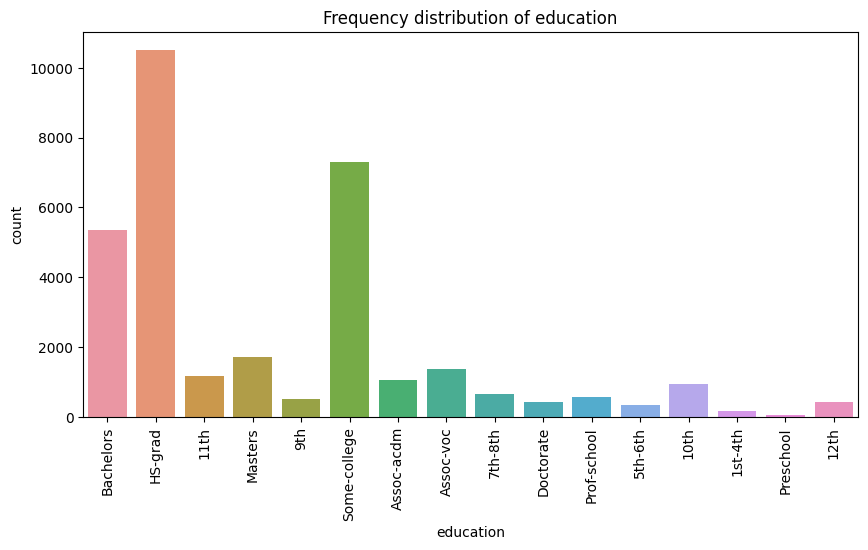

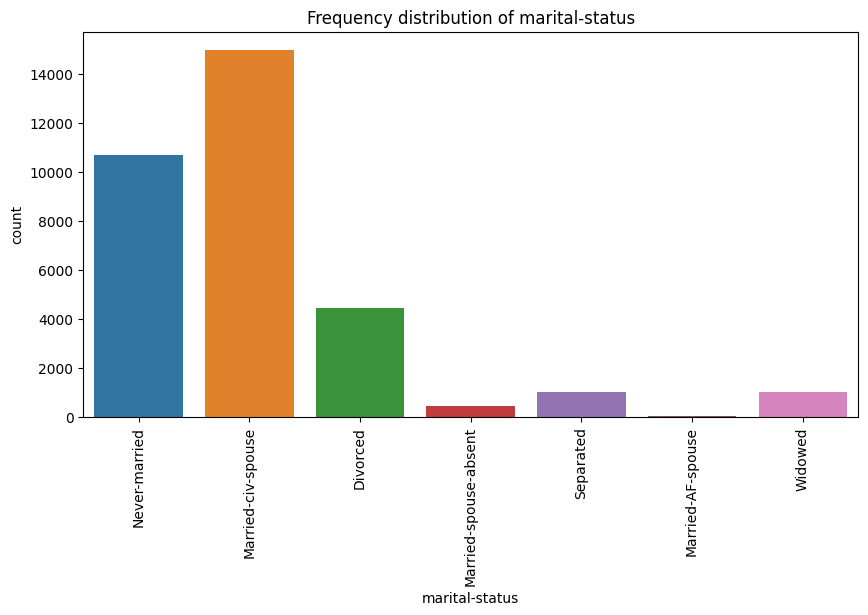

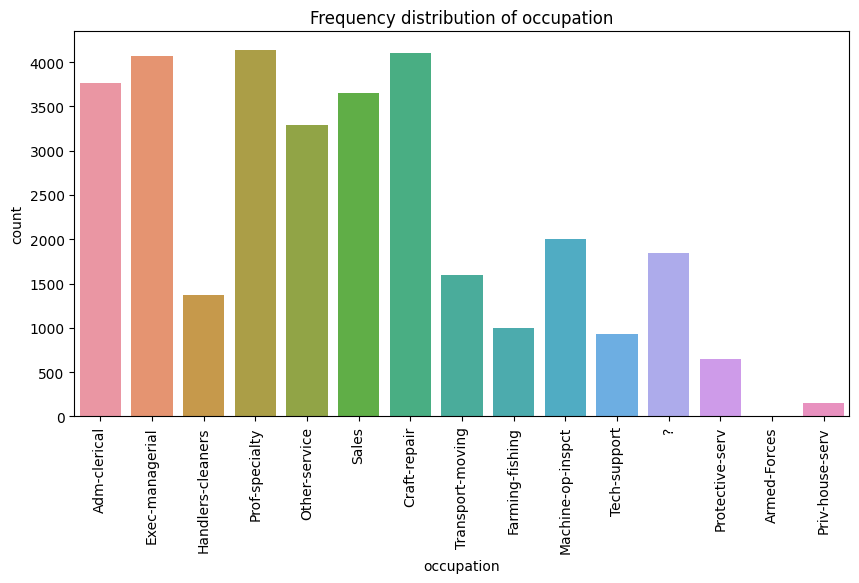

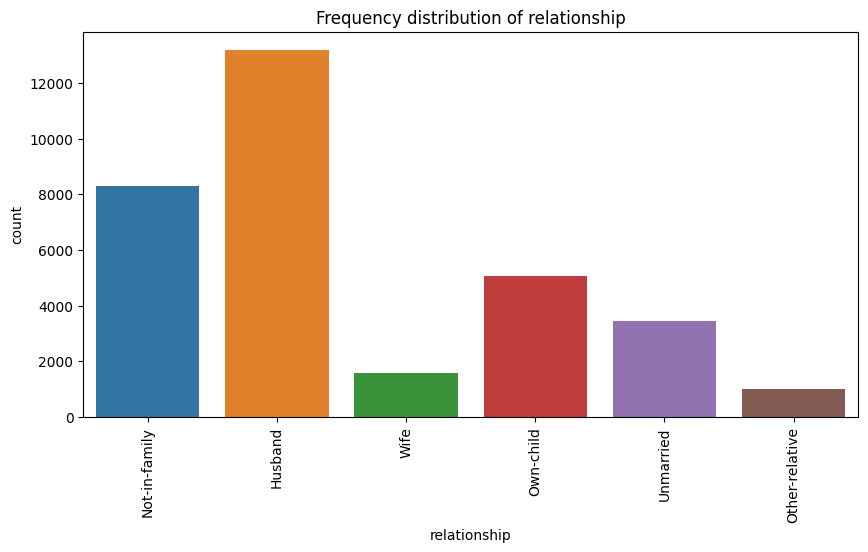

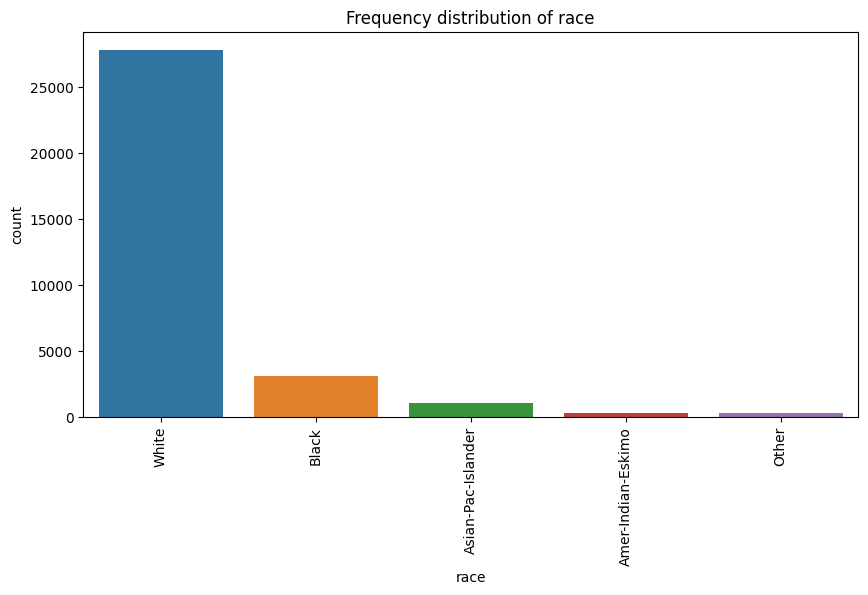

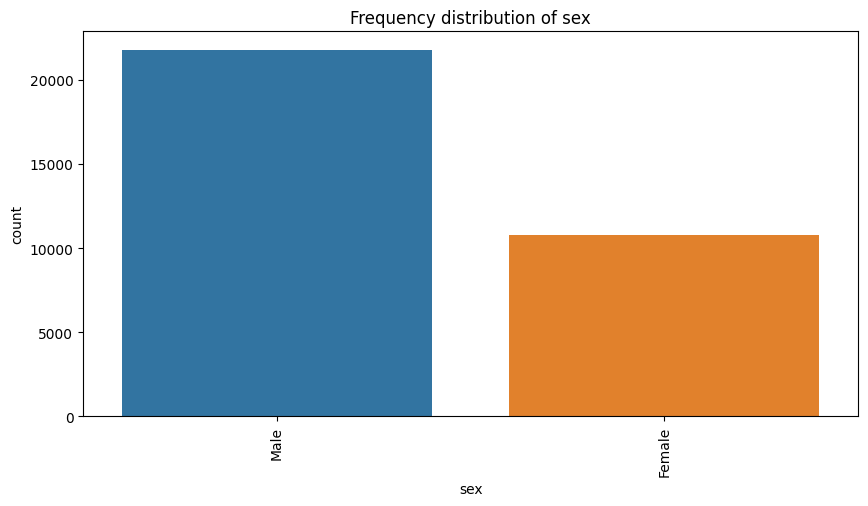

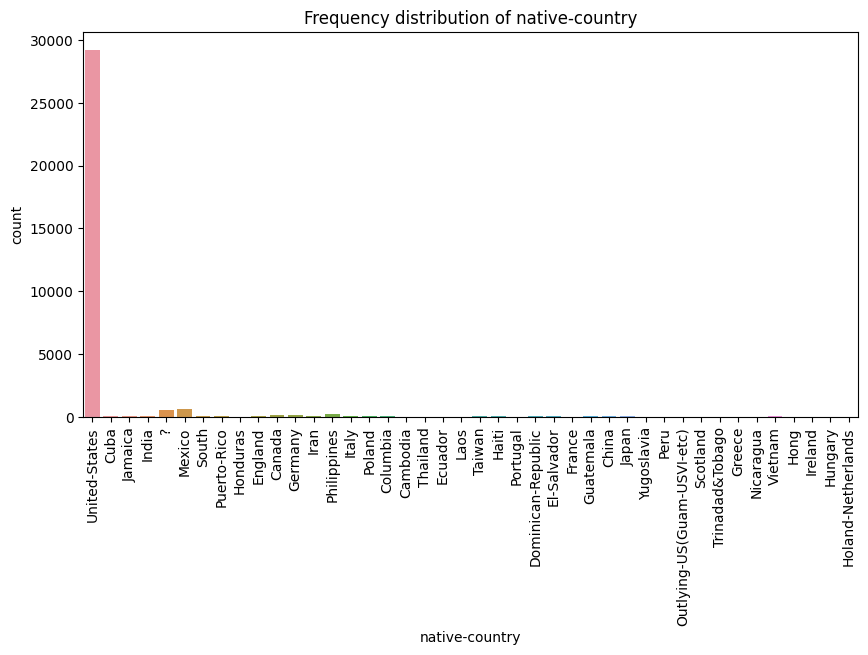

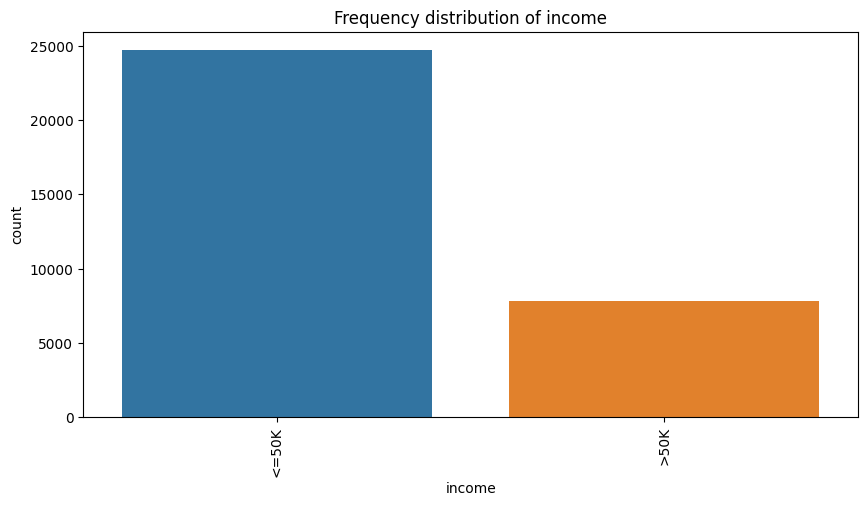

In [4]:
# Frequency distributions for categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=column)
    plt.title(f'Frequency distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

In [5]:

# Define the target and features
X = df.drop(columns=['income'])
y = df['income']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [6]:

# Define the preprocessor
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('income')  # Remove the target column

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [7]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Create the model with the suggested hyperparameters
    dt_classifier = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', dt_classifier)
    ])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
    return scores.mean()


In [8]:
# Check if the hyperparameters are already stored in the JSON file

model_name = 'Decision Tree'
json_file = f'{model_name}.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        best_params = json.load(file)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Remove the 'model' key from best_params if it exists
best_params.pop('model', None)

# Create the model with the best hyperparameters
dt_classifier = DecisionTreeClassifier(**best_params)

# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train)
# Check if the JSON file contains hyperparameters
if 'criterion' in best_params:
    # Use the hyperparameters from the JSON file
    dt_classifier = DecisionTreeClassifier(**best_params)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

    # Create the model with the best hyperparameters
    dt_classifier = DecisionTreeClassifier(**best_params)

Best Hyperparameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}


In [9]:
# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=3,
                                        min_samples_split=7))])

In [10]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.856238   0.856238   0.85834933 0.85505855 0.85333077]
Mean cross-validation score: 0.8558429324117529


In [11]:
# Predict on the test data
y_test_pred = pipeline.predict(X_test)

In [69]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, mean_absolute_error
)
from sklearn.preprocessing import LabelEncoder

# Encode the labels to numerical values
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # e.g., '<=50K' -> 0, '>50K' -> 1
y_test_pred_encoded = label_encoder.transform(y_test_pred)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Classification metrics
precision = precision_score(y_test, y_test_pred, pos_label=">50K")
recall = recall_score(y_test, y_test_pred, pos_label=">50K")
f1 = f1_score(y_test, y_test_pred, pos_label=">50K")

# Regression metrics
r2 = r2_score(y_test_encoded, y_test_pred_encoded)
mae = mean_absolute_error(y_test_encoded, y_test_pred_encoded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")


Test Accuracy: 0.8602794411177644
Precision: 0.8040665434380776
Recall: 0.5548469387755102
F1 Score: 0.6566037735849056
R2 Score: 0.23561859020655773
Mean Absolute Error (MAE): 0.13972055888223553


In [13]:
# Generate classification report for the test set
test_report = classification_report(y_test, y_test_pred)
print("Test Classification Report:\n", test_report)

Test Classification Report:
               precision    recall  f1-score   support

       <=50K       0.87      0.96      0.91      4945
        >50K       0.80      0.55      0.66      1568

    accuracy                           0.86      6513
   macro avg       0.84      0.76      0.78      6513
weighted avg       0.86      0.86      0.85      6513



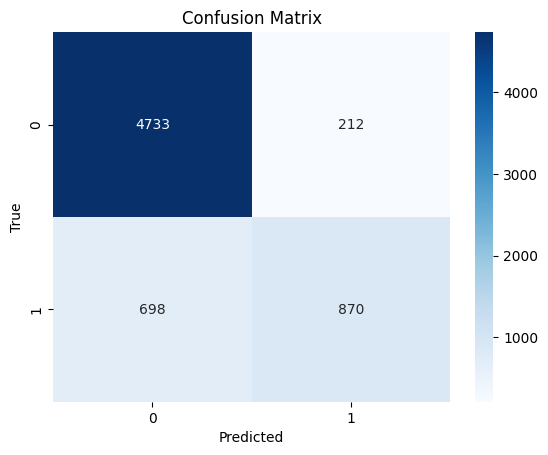

In [14]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

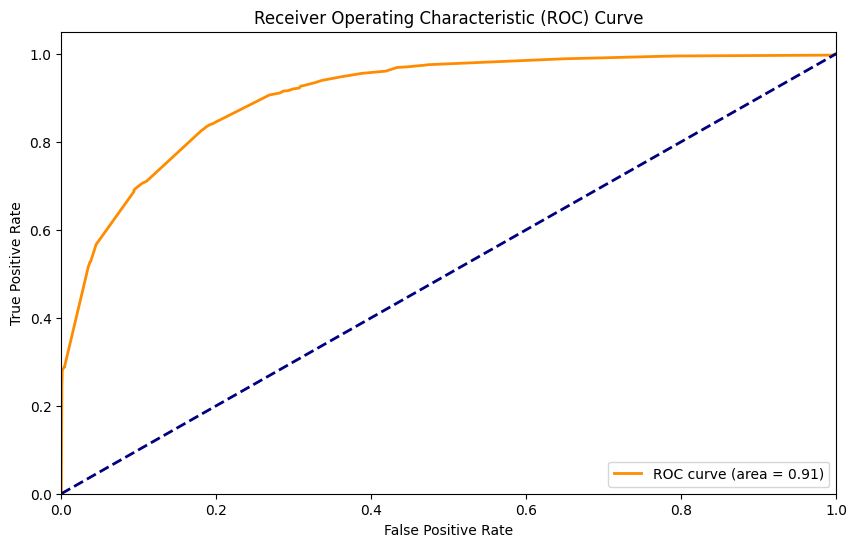

Fidelity: 0.8602794411177644


c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


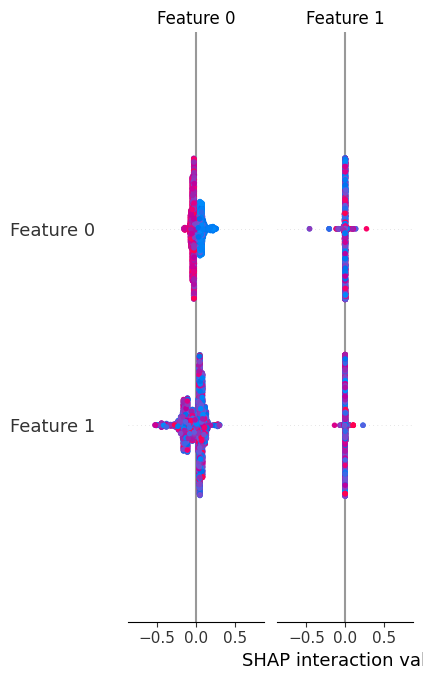

In [15]:

import shap
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Transform X_test using the preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Convert sparse matrix to dense matrix
X_test_transformed_dense = X_test_transformed.toarray()

# Calculate SHAP values
explainer = shap.TreeExplainer(dt_classifier)
shap_values = explainer.shap_values(X_test_transformed_dense)

# Plot ROC-AUC curve
y_test_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba, pos_label='>50K')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate fidelity
fidelity = accuracy_score(y_test, y_test_pred)
print("Fidelity:", fidelity)

# Explainability using SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed_dense)


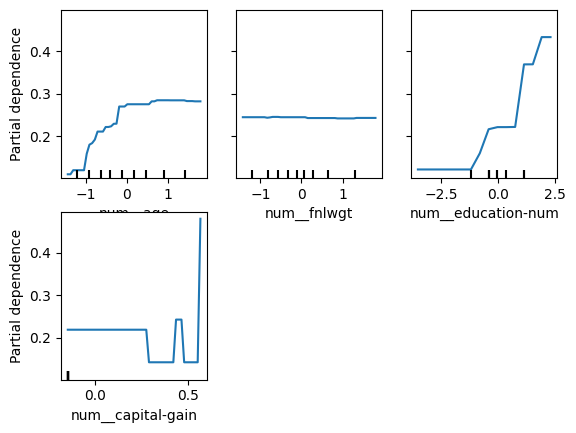

Fidelity: 0.8602794411177644


In [43]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Select features to analyze (use indices or names)
features = [i for i in range(0, 4)] # Modify based on the features you want to analyze
PartialDependenceDisplay.from_estimator(
    dt_classifier,  # Use the model instead of the pipeline
    X_test_transformed_dense,  # Transformed data
    features=features,
    feature_names=preprocessor.get_feature_names_out(),
    grid_resolution=50
)
plt.show()

# Fidelity remains the same
y_test_pred = pipeline.predict(X_test)
fidelity = accuracy_score(y_test, y_test_pred)
print("Fidelity:", fidelity)


In [30]:
from treeinterpreter import treeinterpreter as ti
import pandas as pd

# Get predictions, biases, and contributions
predictions, biases, contributions = ti.predict(dt_classifier, X_test_transformed_dense)

# Select contributions for the positive class (>50K)
positive_class_index = 1  # Index of the positive class
contributions_positive_class = contributions[:, :, positive_class_index]

# Convert contributions into a DataFrame
feature_names = preprocessor.get_feature_names_out()
contributions_df = pd.DataFrame(contributions_positive_class, columns=feature_names)

# Display contributions for the first instance
instance_index = 0
print(f"Feature contributions for instance {instance_index}:")
print(contributions_df.iloc[instance_index])

# Fidelity remains the same
y_test_pred = pipeline.predict(X_test)
fidelity = accuracy_score(y_test, y_test_pred)
print("Fidelity:", fidelity)


Feature contributions for instance 0:
num__age                              -0.105145
num__fnlwgt                            0.000000
num__education-num                     0.105425
num__capital-gain                     -0.015993
num__capital-loss                     -0.005701
                                         ...   
cat__native-country_Thailand           0.000000
cat__native-country_Trinadad&Tobago    0.000000
cat__native-country_United-States      0.000000
cat__native-country_Vietnam            0.000000
cat__native-country_Yugoslavia         0.000000
Name: 0, Length: 108, dtype: float64
Fidelity: 0.8602794411177644


In [70]:
# Store metrics
metrics_data = []
# Append results
metrics_data.append({
    "Model": model_name,
    "Accuracy": test_accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC-AUC": roc_auc,
    "Fidelity": fidelity,
    "R2_Score": r2,
    "Mean Absolute Error": mae
})

# Save metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv("decision_tree_metrics.csv", index=False)

In [59]:
import numpy as np
import pandas as pd
import joblib  # For loading model files
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_absolute_error, r2_score, r2_score, mean_absolute_error
)
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt


In [60]:
def evaluate_model_performance(y_true, y_pred, y_proba):
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['Recall'] = recall_score(y_true, y_pred, average='weighted')
    metrics['F1 Score'] = f1_score(y_true, y_pred, average='weighted')
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_proba, multi_class='ovr')
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['R2'] = r2_score(y_true, y_pred)
    return metrics


In [61]:
def calculate_fidelity(X_test, model, explainer):
    lime_predictions = []
    for i in range(len(X_test)):
        exp = explainer.explain_instance(X_test[i], model.predict_proba)
        lime_pred = np.argmax(exp.local_exp[1])  # Get LIME's prediction
        lime_predictions.append(lime_pred)
    return accuracy_score(model.predict(X_test), lime_predictions)

def calculate_sparsity(explainer, X_test, num_features=5):
    sparsity_scores = []
    for i in range(len(X_test)):
        exp = explainer.explain_instance(X_test[i], pipeline.predict_proba, num_features=num_features)
        sparsity_scores.append(len(exp.local_exp[1]))
    return np.mean(sparsity_scores)


In [58]:
import joblib

# Assuming the model is trained in your .ipynb session and available in memory
# Replace 'model' with the actual variable holding your trained model
joblib.dump(dt_classifier, 'decision_tree.pkl')

print("Model saved successfully as 'decision_tree.pkl'")


Model saved successfully as 'decision_tree.pkl'


In [65]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, r2_score
)

def calculate_metrics(y_test, y_test_pred, y_test_proba, X_test, model, explainer, pos_label=">50K"):
    # Core performance metrics
    metrics = {}
    metrics['Test Accuracy'] = accuracy_score(y_test, y_test_pred)
    metrics['Precision'] = precision_score(y_test, y_test_pred, pos_label=pos_label, average='binary')
    metrics['Recall'] = recall_score(y_test, y_test_pred, pos_label=pos_label, average='binary')
    metrics['F1 Score'] = f1_score(y_test, y_test_pred, pos_label=pos_label, average='binary')
    metrics['ROC-AUC'] = roc_auc_score(y_test, y_test_proba[:, 1])  # Class 1 probabilities

    # Regression metrics
    metrics['R2 Score'] = r2_score(y_test, y_test_pred)
    metrics['MAE'] = mean_absolute_error(y_test, y_test_pred)

    # Fidelity calculation
    lime_predictions = []
    for i in range(len(X_test)):
        exp = explainer.explain_instance(X_test[i], model.predict_proba)
        lime_pred = np.argmax(exp.local_exp[1])  # Get LIME's prediction
        lime_predictions.append(lime_pred)
    metrics['Fidelity'] = accuracy_score(model.predict(X_test), lime_predictions)

    # Sparsity calculation
    sparsity_scores = []
    for i in range(len(X_test)):
        exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=5)
        sparsity_scores.append(len(exp.local_exp[1]))
    metrics['Sparsity'] = np.mean(sparsity_scores)

    return metrics


# Example usage:
# Assuming `y_test`, `y_test_pred`, `y_test_proba`, `X_test`, `model`, and `explainer` are already defined
metrics = calculate_metrics(y_test, y_test_pred, y_test_proba, X_test, dt_classifier, explainer)

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame([metrics])

# Save metrics to a CSV file
metrics_df.to_csv('model_test_metrics.csv', index=False)

print("Metrics saved to 'model_test_metrics.csv'")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed